In [109]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.impute import KNNImputer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import TimeSeriesSplit
from sklearn.ensemble import RandomForestRegressor, StackingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
import xgboost as xgb
import warnings
from statsmodels.tsa.seasonal import STL
import optuna

from statsmodels.tsa.stattools import adfuller
import pmdarima as pm
from pmdarima.arima import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX

warnings.filterwarnings('ignore')


plt.style.use('fivethirtyeight')


# Forecasting Average Player Count for Steam Games
## Project Overview

In this project, we will develop a model to forecast the average player count for a specific Steam game in a given month. The process involves data exploration, preprocessing, feature engineering, and finally, building a sophisticated machine learning pipeline. By predicting player counts, we aim to provide insights into player engagement, which can inform decisions related to marketing strategies.
Authors
- Aden Letchworth
- Fienna Angeline
- Gabriel Bermudez

## Dataset Overview

- Name of the Dataset: Popularity of Games on Steam
- Dataset URL: View Dataset
- License: CC0: Public Domain
- Features:
    - gamename - The title of the game.
    - year - Observation year.
    - month - Observation month.
    - avg - Average number of concurrent players.
    - gain - Change in average player count from the previous month.
    - peak - Maximum number of concurrent players.
    - avg_peak_perc - Percentage of average players relative to the peak count.

## Methodology

The project will start with a thorough data exploration to understand the dynamics of player counts across different games. After initial exploration, the data will undergo preprocessing and feature engineering to prepare it for modeling. We will use Optuna to optimize a machine learning pipeline that includes models like XGBoost, RandomForest, and SARIMA, combined into a stacked model with a Linear Regression meta-model. The performance of the stacked model will be compared against individual models and a neural network approach using LSTM to establish the most effective forecasting method.

## Data Exploration

In this initial phase of our project, we'll look into the dataset to understand its structure and identify potential preprocessing and feature engineering strategies. This thorough examination will set the foundation for our analytical approach and ensure we handle the data effectively to optimize our forecasting model.

In [110]:
# Load the data
data_path = './Data/SteamCharts 2.csv'
df = pd.read_csv(data_path, encoding='unicode_escape') # Needs special encoding to read the file

In [111]:
df.head()

,gamename,year,month,avg,gain,peak,avg_peak_perc
0,Counter-Strike: Global Offensive,2021,February,741013.24,-2196.42,1123485,65.9567%
1,Counter-Strike: Global Offensive,2021,January,743209.66,25405.91,1124553,66.0893%
2,Counter-Strike: Global Offensive,2020,December,717803.75,49049.17,1164396,61.646%
3,Counter-Strike: Global Offensive,2020,November,668754.58,55087.89,1037464,64.4605%
4,Counter-Strike: Global Offensive,2020,October,613666.69,6816.37,943876,65.0156%


Upon examining the first few entries of our dataset, we observe six columns, consistent with our dataset description. Key observations include the need to format the `avg_peak_perc` column to remove the percentage symbol for computational convenience. The gamename column will require encoding to transform categorical data into a machine-readable format. The month field should be converted to a numerical format for easier analysis, and it would be beneficial to create a consolidated date column from the year and month fields to aid in time-series visualization and modeling

In [112]:
df.query('year == 2020')

,gamename,year,month,avg,gain,peak,avg_peak_perc
2,Counter-Strike: Global Offensive,2020,December,717803.75,49049.17,1164396,61.646%
3,Counter-Strike: Global Offensive,2020,November,668754.58,55087.89,1037464,64.4605%
4,Counter-Strike: Global Offensive,2020,October,613666.69,6816.37,943876,65.0156%
5,Counter-Strike: Global Offensive,2020,September,606850.32,-33107.34,977769,62.0648%
6,Counter-Strike: Global Offensive,2020,August,639957.66,14056.85,925348,69.1586%
...,...,...,...,...,...,...,...
83750,Steel Division: Normandy 44,2020,May,143.79,19.94,353,40.7337%
83751,Steel Division: Normandy 44,2020,April,123.85,-2.47,244,50.7582%
83752,Steel Division: Normandy 44,2020,March,126.32,24.71,280,45.1143%
83753,Steel Division: Normandy 44,2020,February,101.61,-4.10,231,43.987%


Further querying reveals that our dataset includes entries for multiple games each month, rather than just the most popular game per month. This structure necessitates aggregation by gamename during preprocessing to ensure that our model captures trends specific to each game. This multi-game per date format increases the complexity of our preprocessing steps, as we need to account for inter-game variations when aggregating data.

In [113]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 83789 entries, 0 to 83788
Data columns (total 7 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   gamename       83789 non-null  object 
 1   year           83789 non-null  int64  
 2   month          83789 non-null  object 
 3   avg            83789 non-null  float64
 4   gain           82529 non-null  float64
 5   peak           83789 non-null  int64  
 6   avg_peak_perc  83789 non-null  object 
dtypes: float64(2), int64(2), object(3)
memory usage: 4.5+ MB


This shows our dataset dimensions as (83789, 7), indicating a good dataset size that supports a wide variety of model types without significant limitations. However, as noted earlier, the `avg_peak_perc` column still requires parsing to convert it from a string to a numeric format. Apart from this, the data types appear appropriate for our subsequent analyses, setting a solid stage for the preprocessing phase.

In [114]:
# Get missing values per column
df.isna().sum()

gamename            0
year                0
month               0
avg                 0
gain             1260
peak                0
avg_peak_perc       0
dtype: int64

We can see we have quite a few missing values for the `gain` column, which isn't a problem because we can impute it using calculations. Since we are going to due preprocessing that this gain is dependent on, we will drop it for now then add it back on later to ensure data integrity is maintained. 

In [115]:
# Drop gain column
df.drop(['gain'], axis=1, inplace=True)

In [116]:
df['avg_peak_perc'] = df['avg_peak_perc'].str.rstrip('%').astype(float) / 100

Before we can visualize our data efficiently we must create a date type and make it the index of our dataframe. In the following code cell, we are going to map the months to their corresponding numerical representations. We will then combine `year` with `month` to create `date` which will be sorted as our index.

In [117]:
#Encodes Months to Numbers
month_to_num = { 
    'January': 1, 'February': 2, 'March': 3, 'April': 4, 'May': 5, 'June': 6,
    'July': 7, 'August': 8, 'September': 9, 'October': 10, 'November': 11, 'December': 12
}

# Convert month to numerical representation
df['month'] = df['month'].str.strip() # Strip whitespace
df['month'] = df['month'].map(month_to_num) # Map month names to numbers

# Add date column and make it df index 
df['date'] = pd.to_datetime(df[['year', 'month']].assign(day=1))
df.set_index('date', inplace=True)
df.sort_index(inplace=True)

In [118]:
# Calculate global averages
global_avg = df.groupby('date')['avg'].mean()
global_peak = df.groupby('date')['peak'].mean()
global_avg_peak_perc = df.groupby('date')['avg_peak_perc'].mean()

df['date'] = df.index

# Map global averages back to the corresponding columns
df['avg'] = df['date'].map(global_avg)
df['peak'] = df['date'].map(global_peak)
df['avg_peak_perc'] = df['date'].map(global_avg_peak_perc)

# Drop duplicates 
df = df.drop_duplicates(subset=['date', 'avg', 'peak', 'avg_peak_perc'])
df.drop('gamename', axis=1, inplace=True)

df.head(20)

,year,month,avg,peak,avg_peak_perc,date
date,,,,,,
2012-07-01,2012,7,2087.497843,3719.946078,0.464471,2012-07-01
2012-08-01,2012,8,1877.019767,3762.600000,0.451802,2012-08-01
2012-09-01,2012,9,1928.878836,4028.616379,0.409500,2012-09-01
2012-10-01,2012,10,1695.099350,4081.666667,0.376651,2012-10-01
2012-11-01,2012,11,1725.741120,3823.347490,0.354860,2012-11-01
2012-12-01,2012,12,1879.577844,4020.765799,0.347141,2012-12-01
2013-01-01,2013,1,2027.081392,4234.428571,0.360723,2013-01-01
2013-02-01,2013,2,1826.596512,3605.975089,0.392439,2013-02-01
2013-03-01,2013,3,1831.336225,3900.096026,0.359327,2013-03-01


Text(0.5, 1.0, 'Average Players Per Month')

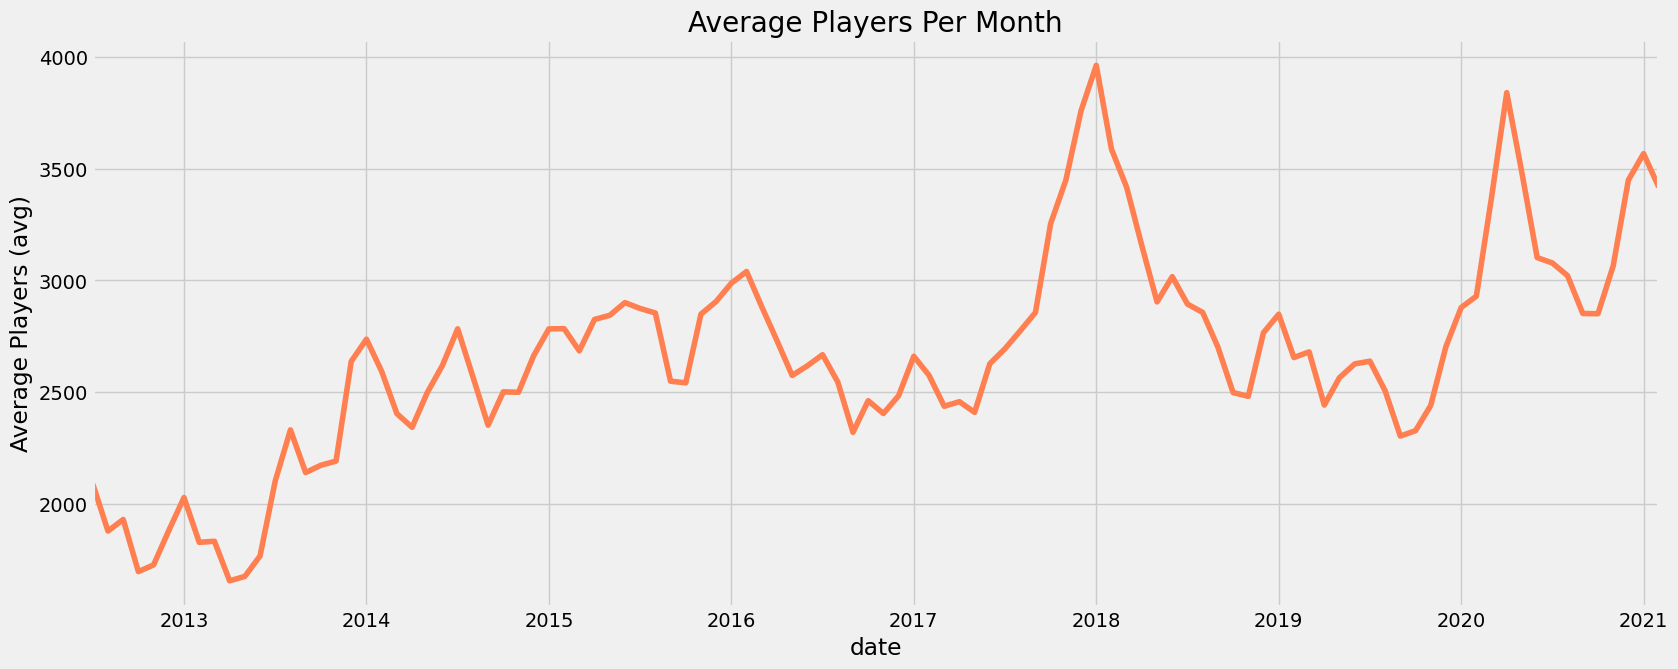

In [119]:
fig, ax = plt.subplots(figsize=(18,7))
df['avg'].plot(color='coral', ax=ax)
ax.set_ylabel('Average Players (avg)')
ax.set_title('Average Players Per Month')

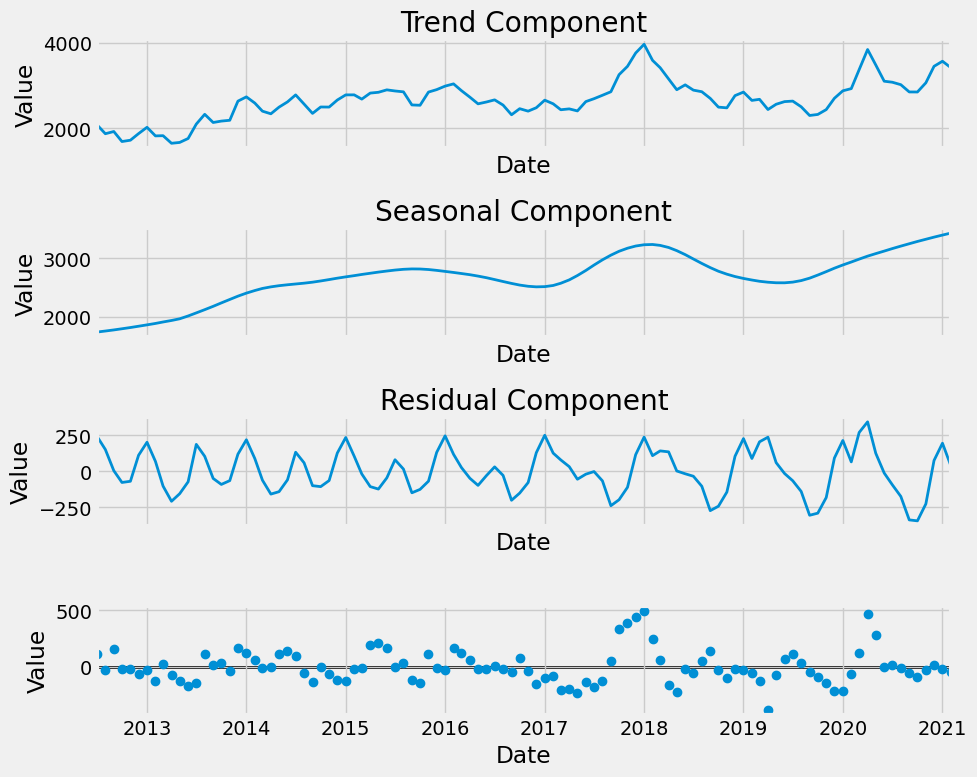

In [120]:
# Apply STL
stl = STL(df['avg'], seasonal=13)  
result = stl.fit()

# Add STL features to df
df['trend'] = result.trend
df['seasonal'] = result.seasonal
df['residual'] = result.resid

plt.rc('lines', linewidth=2) 

fig = result.plot() 
fig.set_figheight(8)  
fig.set_figwidth(10) 

axes = fig.get_axes() 
axes[0].set_title('Trend Component')  
axes[1].set_title('Seasonal Component')  
axes[2].set_title('Residual Component')  

for ax in axes:
    ax.set_xlabel('Date')  
    ax.set_ylabel('Value') 
    ax.grid(True)  

plt.tight_layout()  
plt.show()  

Text(0.5, 1.0, 'Peak Players Per Month')

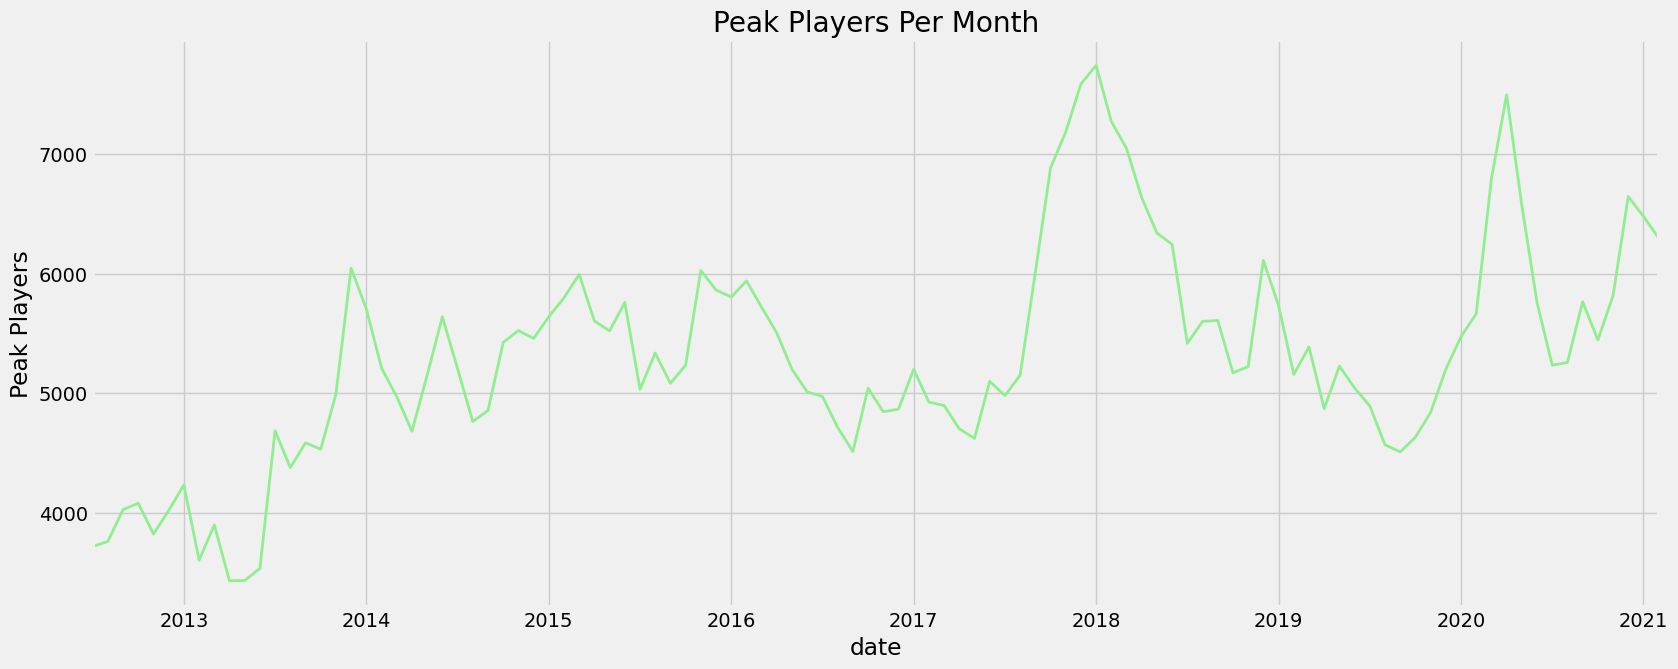

In [122]:
fig, ax = plt.subplots(figsize=(18,7))
df['peak'].plot(color='lightgreen', ax=ax)
ax.set_ylabel('Peak Players')
ax.set_title('Peak Players Per Month')

In [123]:
df['gain'] = df['avg'].pct_change() * 100
df = df.replace([np.inf, -np.inf], np.nan)

Text(0.5, 1.0, 'Gain of Steam Games Popularity')

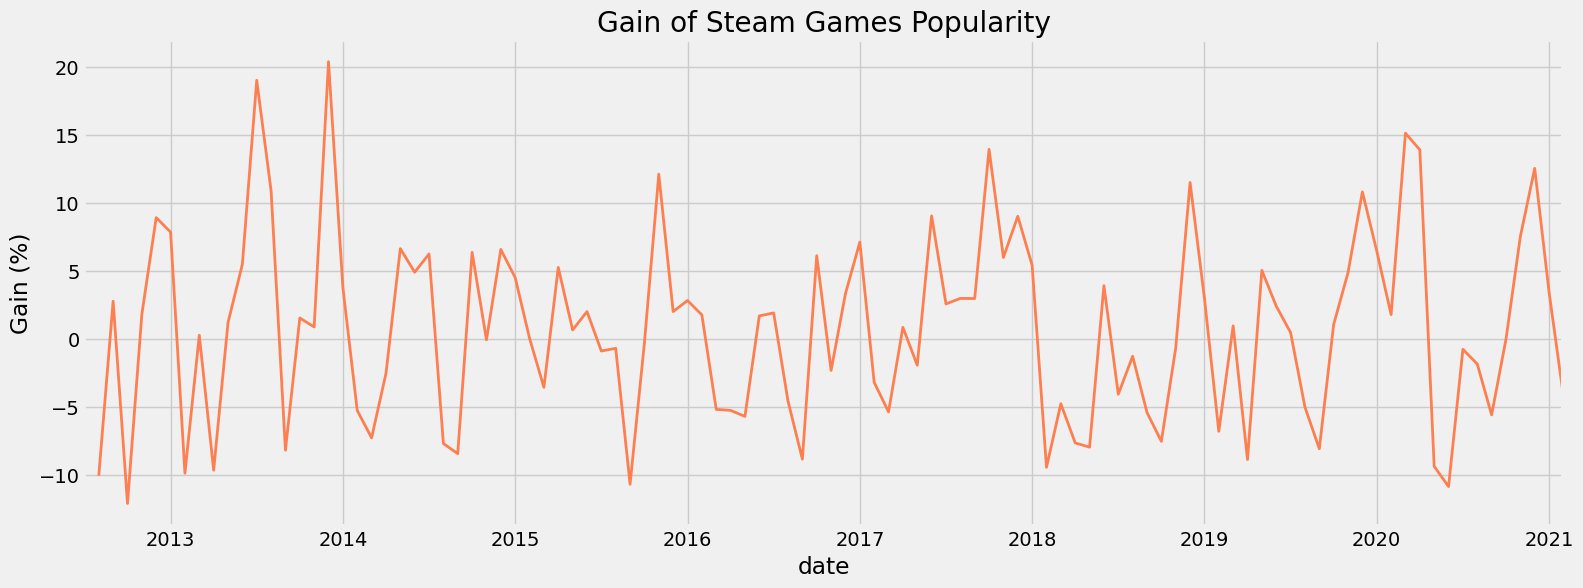

In [125]:
fig, ax = plt.subplots(figsize=(17, 6))

df['gain'].plot(ax=ax, color='coral', label='Gain')
ax.set_ylabel('Gain (%)')
ax.set_title('Gain of Steam Games Popularity')

In [126]:
df = df.drop('date', axis=1).sort_values(by=['date'])

# Create lag features
features = ['avg', 'gain', 'peak', 'avg_peak_perc']
for feature in features:
    df[f'{feature}_lag_1'] = df[f'{feature}'].shift(1)
    df[f'{feature}_lag_2'] = df[f'{feature}'].shift(2)


# Calculate rolling averages and standard deviations for 7 and 30 day windows
features = ['avg']
rolling_windows = [7, 30]
for window in rolling_windows:
    for feature in features:
        df[f'{feature}_rolling_{window}'] = df[feature].rolling(window=window, min_periods=1).mean()
        df[f'std_rolling_{window}'] = df[feature].rolling(window=window, min_periods=1).std()

imputer = KNNImputer(n_neighbors=5, weights='uniform')

columns_to_impute = [col for col in df.columns if df[col].isna().sum() > 0]
    
df[columns_to_impute] = imputer.fit_transform(df[columns_to_impute])
    
df.isna().sum()

year                   0
month                  0
avg                    0
peak                   0
avg_peak_perc          0
trend                  0
seasonal               0
residual               0
gain                   0
avg_lag_1              0
avg_lag_2              0
gain_lag_1             0
gain_lag_2             0
peak_lag_1             0
peak_lag_2             0
avg_peak_perc_lag_1    0
avg_peak_perc_lag_2    0
avg_rolling_7          0
std_rolling_7          0
avg_rolling_30         0
std_rolling_30         0
dtype: int64

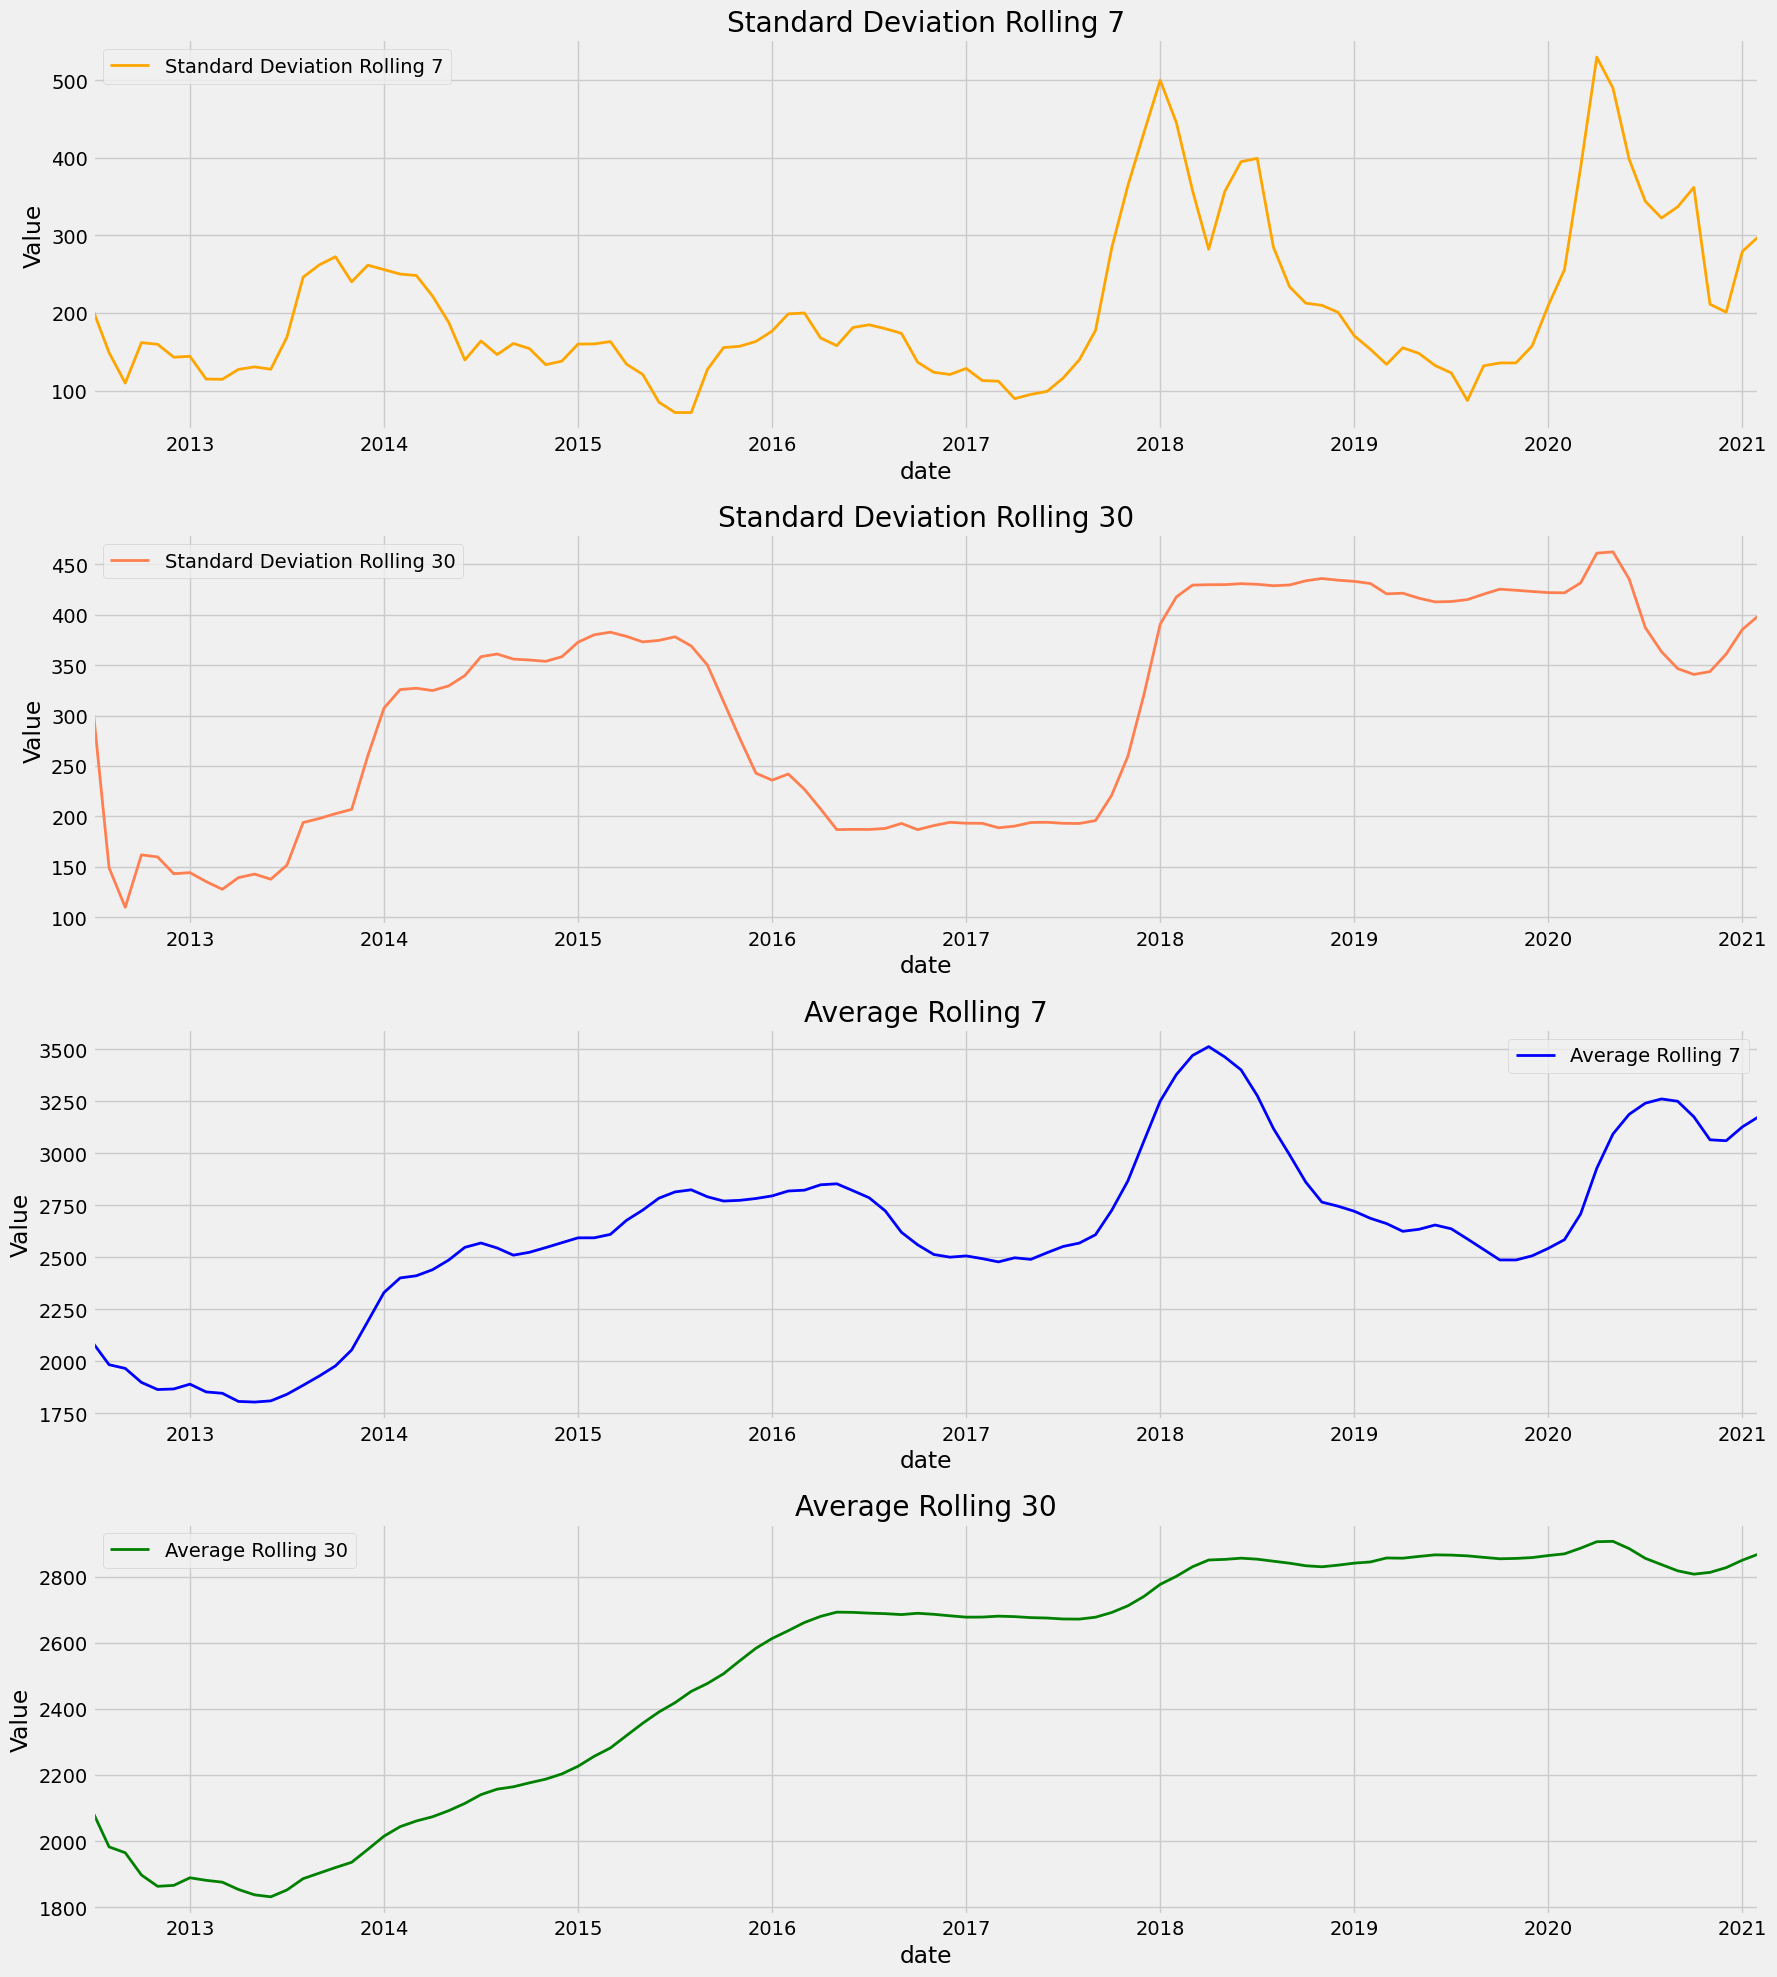

In [132]:
fig, axs = plt.subplots(4, 1, figsize=(18, 20))  # Adjust the size as necessary

df['std_rolling_7'].plot(ax=axs[0], color='orange', label='Standard Deviation Rolling 7')
axs[0].set_title('Standard Deviation Rolling 7')
axs[0].set_ylabel('Value')
axs[0].legend()

df['std_rolling_30'].plot(ax=axs[1], color='coral', label='Standard Deviation Rolling 30')
axs[1].set_title('Standard Deviation Rolling 30')
axs[1].set_ylabel('Value')
axs[1].legend()

df['avg_rolling_7'].plot(ax=axs[2], color='blue', label='Average Rolling 7')
axs[2].set_title('Average Rolling 7')
axs[2].set_ylabel('Value')
axs[2].legend()

df['avg_rolling_30'].plot(ax=axs[3], color='green', label='Average Rolling 30')
axs[3].set_title('Average Rolling 30')
axs[3].set_ylabel('Value')
axs[3].legend()

# Automatically adjust the layout
plt.tight_layout()

# Show the plots
plt.show()

In [133]:
# Dickey–Fuller test:
print('Results of Dickey Fuller Test:')
dftest = adfuller(df["avg"], autolag='AIC')

dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
for key,value in dftest[4].items():
    dfoutput['Critical Value (%s)'%key] = value

print(dfoutput)

Results of Dickey Fuller Test:
Test Statistic                  -2.880604
p-value                          0.047650
#Lags Used                       1.000000
Number of Observations Used    102.000000
Critical Value (1%)             -3.496149
Critical Value (5%)             -2.890321
Critical Value (10%)            -2.582122
dtype: float64


In [134]:
# Seasonal - fit stepwise auto-ARIMA
SARIMA_model = pm.auto_arima(df["avg"], start_p=1, start_q=1,
                         test='adf',
                         max_p=3, max_q=3,
                         m=12,
                         start_P=0,
                         seasonal=True,
                         d=None,
                         D=1, 
                         trace=False,
                         error_action='ignore',
                         suppress_warnings=True,
                         stepwise=True
)

In [135]:
scaled_rows = [col for col in df.columns if col not in ['date', 'avg', 'year', 'month']]

scaler = StandardScaler()

df[scaled_rows] = scaler.fit_transform(df[scaled_rows])

df.head()

,year,month,avg,peak,avg_peak_perc,trend,seasonal,residual,gain,avg_lag_1,...,gain_lag_1,gain_lag_2,peak_lag_1,peak_lag_2,avg_peak_perc_lag_1,avg_peak_perc_lag_2,avg_rolling_7,std_rolling_7,avg_rolling_30,std_rolling_30
date,,,,,,,,,,,,,,,,,,,,,
2012-07-01,2012,7,2087.497843,-1.780303,1.379341,-2.316614,1.626504,0.733434,0.000000,0.000000,...,0.003317,0.008849,0.000000,0.015742,0.000000,0.002336,-1.286769,0.000000,-1.157427,5.350074e-16
2012-08-01,2012,8,1877.019767,-1.732699,1.029562,-2.272572,1.011195,-0.179797,-1.568439,-1.227537,...,-0.341667,-0.363847,-1.780058,-1.621398,1.411880,-0.240583,-1.538814,-0.549638,-1.444761,-1.500663e+00
2012-09-01,2012,9,1928.878836,-1.435817,-0.138326,-2.225793,0.032554,1.035170,0.297501,-1.681732,...,-1.575179,-0.538720,-1.732176,-1.743565,1.057786,1.440549,-1.581428,-0.939426,-1.493342,-1.869344e+00
2012-10-01,2012,10,1695.099350,-1.376611,-1.045242,-2.176068,-0.513120,-0.120992,-1.864356,-1.569824,...,0.294360,-1.564583,-1.433552,-1.695896,-0.124509,1.083262,-1.742709,-0.421288,-1.677204,-1.379263e+00
2012-11-01,2012,11,1725.741120,-1.664903,-1.646865,-2.123430,-0.458032,-0.112739,0.158753,-2.074303,...,-1.871667,0.303513,-1.373998,-1.398599,-1.042611,-0.109697,-1.824801,-0.441867,-1.770789,-1.398728e+00


In [138]:
df = df.reset_index('date')
df.to_csv('clean_data.csv', index=False)

In [139]:
df = df.drop(['date'], axis=1)

In [141]:
def tune_rf():
    def objective(trial):
        # Define hyperparameters for the RandomForestRegressor
        params = {
            'n_estimators': trial.suggest_int('n_estimators', 50, 300),
            'max_depth': trial.suggest_int('max_depth', 3, 12),
            'min_samples_split': trial.suggest_int('min_samples_split', 2, 10),
            'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 10),
            'max_features': trial.suggest_float('max_features', 0.1, 1.0)
        }

        # Define the RandomForestRegressor model
        model = RandomForestRegressor(**params)

        # TimeSeriesSplit setup
        n_splits = 3
        tscv = TimeSeriesSplit(n_splits=n_splits)
        rmses = []

        for train_index, test_index in tscv.split(df):
            train = df.iloc[train_index]
            test = df.iloc[test_index]

            # Split data into X and y
            X_train, y_train = train.drop('avg', axis=1), train['avg']
            X_test, y_test = test.drop('avg', axis=1), test['avg']

            # Train model
            model.fit(X_train, y_train)
            # Evaluate the model
            preds = model.predict(X_test)
            rmse = np.sqrt(mean_squared_error(y_test, preds))
            rmses.append(rmse)

        # Calculate average RMSE across all folds
        return np.mean(rmses)


    # Create optuna study with Hyperband pruner and TPE sampler
    study = optuna.create_study(
        direction='minimize',
        pruner=optuna.pruners.HyperbandPruner(),
        sampler=optuna.samplers.TPESampler()
    )

    # Optimize the study
    study.optimize(objective, n_trials=100)

    # Print out best parameters
    print("Best trial:")
    trial = study.best_trial
    print(f" Value: {trial.value}")
    print(" Params: ")
    for key, value in trial.params.items():
        print(f"    {key}: {value}")
        
#tune_rf()

[I 2024-05-09 18:03:39,525] A new study created in memory with name: no-name-8183a090-b1fa-4511-955a-bfb833820d2c


[I 2024-05-09 18:03:41,142] Trial 0 finished with value: 271.15205972218956 and parameters: {'n_estimators': 234, 'max_depth': 8, 'min_samples_split': 10, 'min_samples_leaf': 2, 'max_features': 0.49110032991807673}. Best is trial 0 with value: 271.15205972218956.
[I 2024-05-09 18:03:41,365] Trial 1 finished with value: 293.48893218068065 and parameters: {'n_estimators': 52, 'max_depth': 6, 'min_samples_split': 8, 'min_samples_leaf': 6, 'max_features': 0.38267581840613507}. Best is trial 0 with value: 271.15205972218956.
[I 2024-05-09 18:03:41,686] Trial 2 finished with value: 267.3803508528681 and parameters: {'n_estimators': 91, 'max_depth': 12, 'min_samples_split': 2, 'min_samples_leaf': 5, 'max_features': 0.5528339204583437}. Best is trial 2 with value: 267.3803508528681.
[I 2024-05-09 18:03:42,256] Trial 3 finished with value: 253.67224187599325 and parameters: {'n_estimators': 140, 'max_depth': 9, 'min_samples_split': 7, 'min_samples_leaf': 4, 'max_features': 0.8006718057449097}. 

Best trial:
 Value: 242.08097328442486
 Params: 
    n_estimators: 98
    max_depth: 9
    min_samples_split: 5
    min_samples_leaf: 1
    max_features: 0.7140334407297714


In [142]:
def tune_xgb():
    def objective(trial):
        # Define hyperparameters for the XGBRegressor
        params = {
            'n_estimators': trial.suggest_int('n_estimators', 100, 1000),
            'max_depth': trial.suggest_int('max_depth', 3, 12),
            'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
            'subsample': trial.suggest_float('subsample', 0.5, 1.0),
            'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
            'min_child_weight': trial.suggest_int('min_child_weight', 1, 10)
        }

        # Define the XGBRegressor model
        model = xgb.XGBRegressor(**params)

        # TimeSeriesSplit setup
        n_splits = 3
        tscv = TimeSeriesSplit(n_splits=n_splits)
        rmses = []

        for train_index, test_index in tscv.split(df):
            train = df.iloc[train_index]
            test = df.iloc[test_index]

            # Split data into X and y
            X_train, y_train = train.drop('avg', axis=1), train['avg']
            X_test, y_test = test.drop('avg', axis=1), test['avg']

            # Train model
            model.fit(X_train, y_train, eval_set=[(X_test, y_test)], early_stopping_rounds=50, verbose=False)
            # Evaluate the model
            preds = model.predict(X_test)
            rmse = np.sqrt(mean_squared_error(y_test, preds))
            rmses.append(rmse)

        # Calculate average RMSE across all folds
        return np.mean(rmses)

    # Create optuna study with Hyperband pruner and TPE sampler
    study = optuna.create_study(
        direction='minimize',
        pruner=optuna.pruners.HyperbandPruner(),
        sampler=optuna.samplers.TPESampler()
    )

    # Optimize the study
    study.optimize(objective, n_trials=100)

    # Print out best parameters
    print("Best trial:")
    trial = study.best_trial
    print(f" Value: {trial.value}")
    print(" Params: ")
    for key, value in trial.params.items():
        print(f"    {key}: {value}")
#tune_xgb()

[I 2024-05-09 18:05:37,280] A new study created in memory with name: no-name-2cf94a0e-9b05-49ef-a176-14aec666ac0a


[I 2024-05-09 18:05:38,288] Trial 0 finished with value: 224.53620369193888 and parameters: {'n_estimators': 164, 'max_depth': 11, 'learning_rate': 0.06837204990933933, 'subsample': 0.9608698184659866, 'colsample_bytree': 0.899244186340233, 'min_child_weight': 9}. Best is trial 0 with value: 224.53620369193888.
[I 2024-05-09 18:05:39,025] Trial 1 finished with value: 233.5128206498471 and parameters: {'n_estimators': 275, 'max_depth': 6, 'learning_rate': 0.11419666017734843, 'subsample': 0.744095782318009, 'colsample_bytree': 0.7282222628540688, 'min_child_weight': 5}. Best is trial 0 with value: 224.53620369193888.
[I 2024-05-09 18:05:39,502] Trial 2 finished with value: 224.292552022755 and parameters: {'n_estimators': 444, 'max_depth': 10, 'learning_rate': 0.2084770090767918, 'subsample': 0.5491348357632626, 'colsample_bytree': 0.7825693030053578, 'min_child_weight': 4}. Best is trial 2 with value: 224.292552022755.
[I 2024-05-09 18:05:40,064] Trial 3 finished with value: 226.261153

Best trial:
 Value: 210.28508676103056
 Params: 
    n_estimators: 297
    max_depth: 12
    learning_rate: 0.11532417983895252
    subsample: 0.9181549179350544
    colsample_bytree: 0.9056850195118574
    min_child_weight: 8


In [145]:
import optuna
from sklearn.ensemble import StackingRegressor, RandomForestRegressor
from sklearn.linear_model import Ridge
import xgboost as xgb
from sklearn.metrics import mean_squared_error
import numpy as np

def tune_meta_linear_model():
    def objective(trial):
        # Fixed hyperparameters for base estimators
        rf_params = {
            'n_estimators': 98,
            'max_depth': 9,
            'min_samples_split': 5,
            'min_samples_leaf': 1,
            'max_features': 0.7140334407297714
        }

        xgb_params = {
            'n_estimators': 297,
            'max_depth': 12,
            'learning_rate': 0.11532417983895252,
            'subsample': 0.9181549179350544,
            'colsample_bytree': 0.9056850195118574,
            'min_child_weight': 8
        }

        # Base estimators
        estimators = [
            ('xgb', xgb.XGBRegressor(**xgb_params)),
            ('rf', RandomForestRegressor(**rf_params))
        ]
        
        # Meta estimator with hyperparameters to be tuned
        alpha = trial.suggest_loguniform('alpha', 1e-3, 10)
        meta_estimator = Ridge(alpha=alpha)

        # Stacking Regressor
        model = StackingRegressor(estimators=estimators, final_estimator=meta_estimator)

        # TimeSeriesSplit setup
        tscv = TimeSeriesSplit(n_splits=5)
        rmses = []

        for train_index, test_index in tscv.split(df):
            train = df.iloc[train_index]
            test = df.iloc[test_index]

            X_train, y_train = train.drop('avg', axis=1), train['avg']
            X_test, y_test = test.drop('avg', axis=1), test['avg']

            model.fit(X_train, y_train)
            preds = model.predict(X_test)
            rmse = np.sqrt(mean_squared_error(y_test, preds))
            rmses.append(rmse)

        return np.mean(rmses)

    # Optuna study
    study = optuna.create_study(direction='minimize')
    study.optimize(objective, n_trials=50)  # Adjust the number of trials if necessary

    # Output the best hyperparameters
    print("Best trial:")
    trial = study.best_trial
    print(f" Value: {trial.value}")
    print(" Params: ")
    for key, value in trial.params.items():
        print(f"    {key}: {value}")

#tune_meta_linear_model()

[I 2024-05-09 18:12:41,023] A new study created in memory with name: no-name-6c304ef8-9086-4efd-bfc2-c007a7ac44e0
[I 2024-05-09 18:12:57,514] Trial 0 finished with value: 258.2660755701289 and parameters: {'alpha': 0.10518141327995334}. Best is trial 0 with value: 258.2660755701289.
[I 2024-05-09 18:13:09,505] Trial 1 finished with value: 257.4539238594582 and parameters: {'alpha': 7.651066718486546}. Best is trial 1 with value: 257.4539238594582.
[I 2024-05-09 18:13:24,248] Trial 2 finished with value: 263.9186188250924 and parameters: {'alpha': 0.15151358657987765}. Best is trial 1 with value: 257.4539238594582.
[I 2024-05-09 18:13:44,164] Trial 3 finished with value: 260.57071584164254 and parameters: {'alpha': 0.13703537282667522}. Best is trial 1 with value: 257.4539238594582.
[I 2024-05-09 18:13:59,085] Trial 4 finished with value: 250.900851102479 and parameters: {'alpha': 2.480783667321435}. Best is trial 4 with value: 250.900851102479.
[I 2024-05-09 18:14:14,829] Trial 5 finis

KeyboardInterrupt: 

In [143]:
rf_params = {
    'n_estimators': 98,
    'max_depth': 9,
    'min_samples_split': 5,
    'min_samples_leaf': 1,
    'max_features': 0.7140334407297714
}

xgb_params = {
    'n_estimators': 297,
    'max_depth': 12,
    'learning_rate': 0.11532417983895252,
    'subsample': 0.9181549179350544,
    'colsample_bytree': 0.9056850195118574,
    'min_child_weight': 8
}

# Define other params for models
...


# Put the models into the estimators base
estimators = [
    ('xgb', xgb.XGBRegressor(**xgb_params)),
    ('rf', RandomForestRegressor(**rf_params))
]

# Meta estimator decides how to combine the base estimators
meta_estimator = LinearRegression()

# Define the stacking regressor
stacking_regressor = StackingRegressor(estimators=estimators, final_estimator=meta_estimator)

# Define the features and target variable
features = df.drop('avg', axis=1)
target = df['avg']

# Define the TimeSeriesSplit object
tscv = TimeSeriesSplit(n_splits=5)

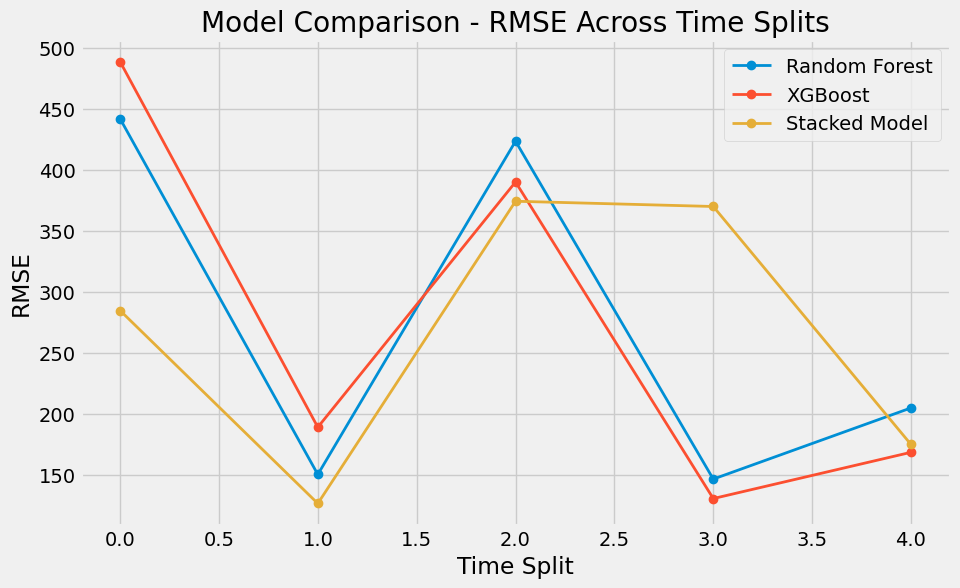

In [144]:
scores_rf = []
scores_xgb = []
scores_stacked = []

for train_idx, test_idx in tscv.split(features):
    X_train, X_test = features.iloc[train_idx], features.iloc[test_idx]
    y_train, y_test = target.iloc[train_idx], target.iloc[test_idx]
    
    # Random Forest model
    model_rf = RandomForestRegressor(**rf_params)
    model_rf.fit(X_train, y_train)
    y_pred_rf = model_rf.predict(X_test)
    rmse_rf = np.sqrt(mean_squared_error(y_test, y_pred_rf))
    scores_rf.append(rmse_rf)

    # XGBoost model
    model_xgb = xgb.XGBRegressor(**xgb_params)
    model_xgb.fit(X_train, y_train)
    y_pred_xgb = model_xgb.predict(X_test)
    rmse_xgb = np.sqrt(mean_squared_error(y_test, y_pred_xgb))
    scores_xgb.append(rmse_xgb)

    # Stacked model
    stacking_regressor.fit(X_train, y_train)
    y_pred_stacked = stacking_regressor.predict(X_test)
    rmse_stacked = np.sqrt(mean_squared_error(y_test, y_pred_stacked))
    scores_stacked.append(rmse_stacked)

# Plotting
fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(scores_rf, label='Random Forest', marker='o')
ax.plot(scores_xgb, label='XGBoost', marker='o')
ax.plot(scores_stacked, label='Stacked Model', marker='o')
ax.set_title('Model Comparison - RMSE Across Time Splits')
ax.set_xlabel('Time Split')
ax.set_ylabel('RMSE')
ax.legend()
plt.show()